In [1]:
%matplotlib inline

In [2]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

/tmp/ipykernel_3291518/2441880800.py:2: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [3]:
import scanpy as sc

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import moscot
from moscot.problems.time import TemporalProblem
import moscot.plotting as mpl
import pandas as pd
import os
import muon

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=200)
                         
import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/

['default', 'despine']


In [4]:
output_dir = "/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/plots/OT_general_analysis"

In [5]:
mudata = muon.read("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/mudata_with_annotation_all.h5mu")

In [6]:
mudata.obs["stage"].value_counts()

stage
E15.5    10333
E14.5     9029
E16.5     3242
Name: count, dtype: int64

In [7]:
mudata.obsm

MuAxisArrays with keys: X_MultiVI, X_umap, atac, rna

In [8]:
adata = mudata["rna"]
adata.obsm["X_MultiVI"] = mudata.obsm["X_MultiVI"]
adata.obsm["X_umap"] = mudata.obsm["X_umap"]
adata.obs["cell_type_refined"] = mudata.obs["cell_type_refined"]

In [9]:
def adapt_time(x):
    if x["stage"]=="E14.5":
        return 14.5
    if x["stage"]=="E15.5":
        return 15.5
    if x["stage"]=="E16.5":
        return 16.5
    raise ValueError

adata.obs['time'] = adata.obs.apply(adapt_time, axis=1)

In [10]:
color_dict = { 'Prlf. Ductal': '#f7b6d2', 'Ductal': '#d62728', 'Imm. Acinar': '#ffeb3b', 'Mat. Acinar': '#98df8a',
    'Alpha': '#1f77b4', 'Beta': '#ff7f0e', 'Delta': '#279e68', 'Eps. progenitors': '#aa40fc', 'Epsilon': '#8c564b',
       'Fev+': '#e377c2', 'Fev+ Alpha': '#b5bd61', 'Fev+ Beta': '#42f5ec', 'Fev+ Delta': '#aec7e8', 'Fev+ Delta,0': '#17becf', 'Fev+ Delta,1':'#98df8a',
      'Ngn3 high cycling': '#adf542',
        'Ngn3 high,0': '#ff9896', 'Ngn3 high': '#ff9896', 'Ngn3 high,1':'#f0b98d', 'Ngn3 low': '#c5b0d5'
}


In [11]:
adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")
adata.uns["cell_type_colors"] = [color_dict[ct] for ct in adata.obs["cell_type"].cat.categories]

In [12]:
#adata = adata[adata.obs["time"].isin((14.5, 15.5))].copy()

# Geodesic Sinkhorn

In [13]:
dfs = {}
batch_column = "time"
unique_batches = [14.5, 15.5, 16.5]
for i in range(len(unique_batches) - 1):
    batch1 = unique_batches[i]
    batch2 = unique_batches[i + 1]

    indices = np.where((adata.obs[batch_column] == batch1) | (adata.obs[batch_column] == batch2))[0]
    adata_subset = adata[indices]
    sc.pp.neighbors(adata_subset, use_rep="X_MultiVI")
    dfs[(batch1, batch2)] = (
        pd.DataFrame(
            index=adata_subset.obs_names,
            columns=adata_subset.obs_names,
            data=adata_subset.obsp["connectivities"].A.astype("float64")
        )
    )

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [14]:
adata.obs["time"] = adata.obs["time"].astype("category")

In [15]:
tp0 = TemporalProblem(adata)
tp0 = tp0.score_genes_for_marginals("mouse", "mouse")
tp0 = tp0.prepare("time", joint_attr="X_MultiVI", marginal_kwargs={"scaling": 1.0})

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/git_repos/moscot/src/moscot/problems/time/_mixins.py:986: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not (is_categorical_dtype(col) and is_numeric_dtype(col.cat.categories)):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: Future

In [16]:
tp0[14.5, 15.5].set_graph_xy(dfs[14.5, 15.5], t=100)
tp0[15.5, 16.5].set_graph_xy(dfs[15.5, 16.5], t=100)

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [17]:
tp0.solve(max_iterations=1e7, device='cpu', tau_a=0.99, tau_b=0.99)

INFO     Solving `2` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(10333, 3242)].                                 


/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(9029, 10333)].                                 


/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


TemporalProblem[(15.5, 16.5), (14.5, 15.5)]

In [18]:
order_celltypes = ['Mat. Acinar', 'Imm. Acinar', 'Prlf. Ductal', 'Ductal', 'Ngn3 low', 'Ngn3 high cycling', 'Ngn3 high', 'Eps. progenitors', 'Fev+', 'Fev+ Alpha', 
                   'Fev+ Beta', 'Fev+ Delta', 'Alpha', 'Beta', 'Delta', 'Epsilon']

In [19]:
_ = tp0.cell_transition(14.5, 15.5, {"cell_type": order_celltypes}, {"cell_type": order_celltypes}, forward=False)

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

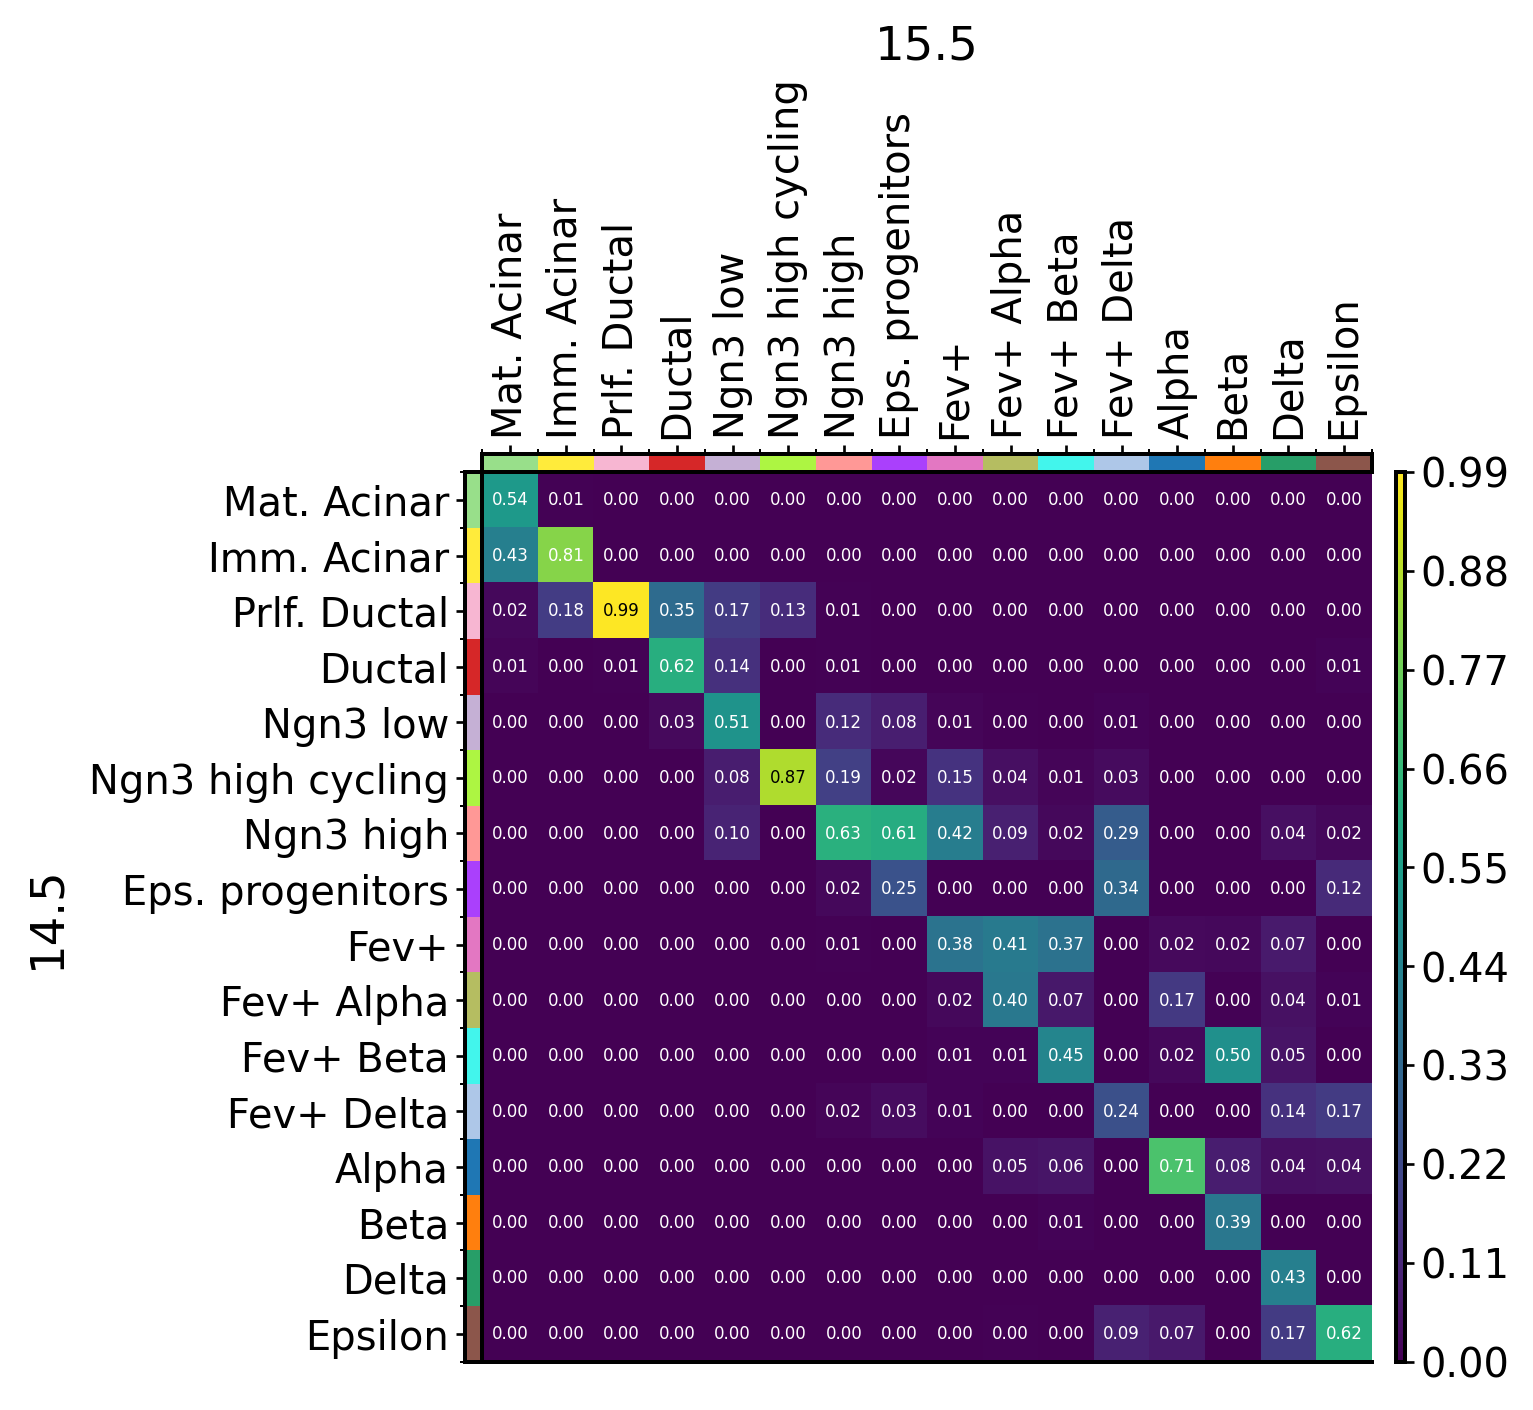

In [20]:
mpl.cell_transition(tp0, dpi=120, fontsize=5)

In [21]:
_ = tp0.cell_transition(15.5, 16.5, {"cell_type": order_celltypes}, {"cell_type": order_celltypes}, forward=False)

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

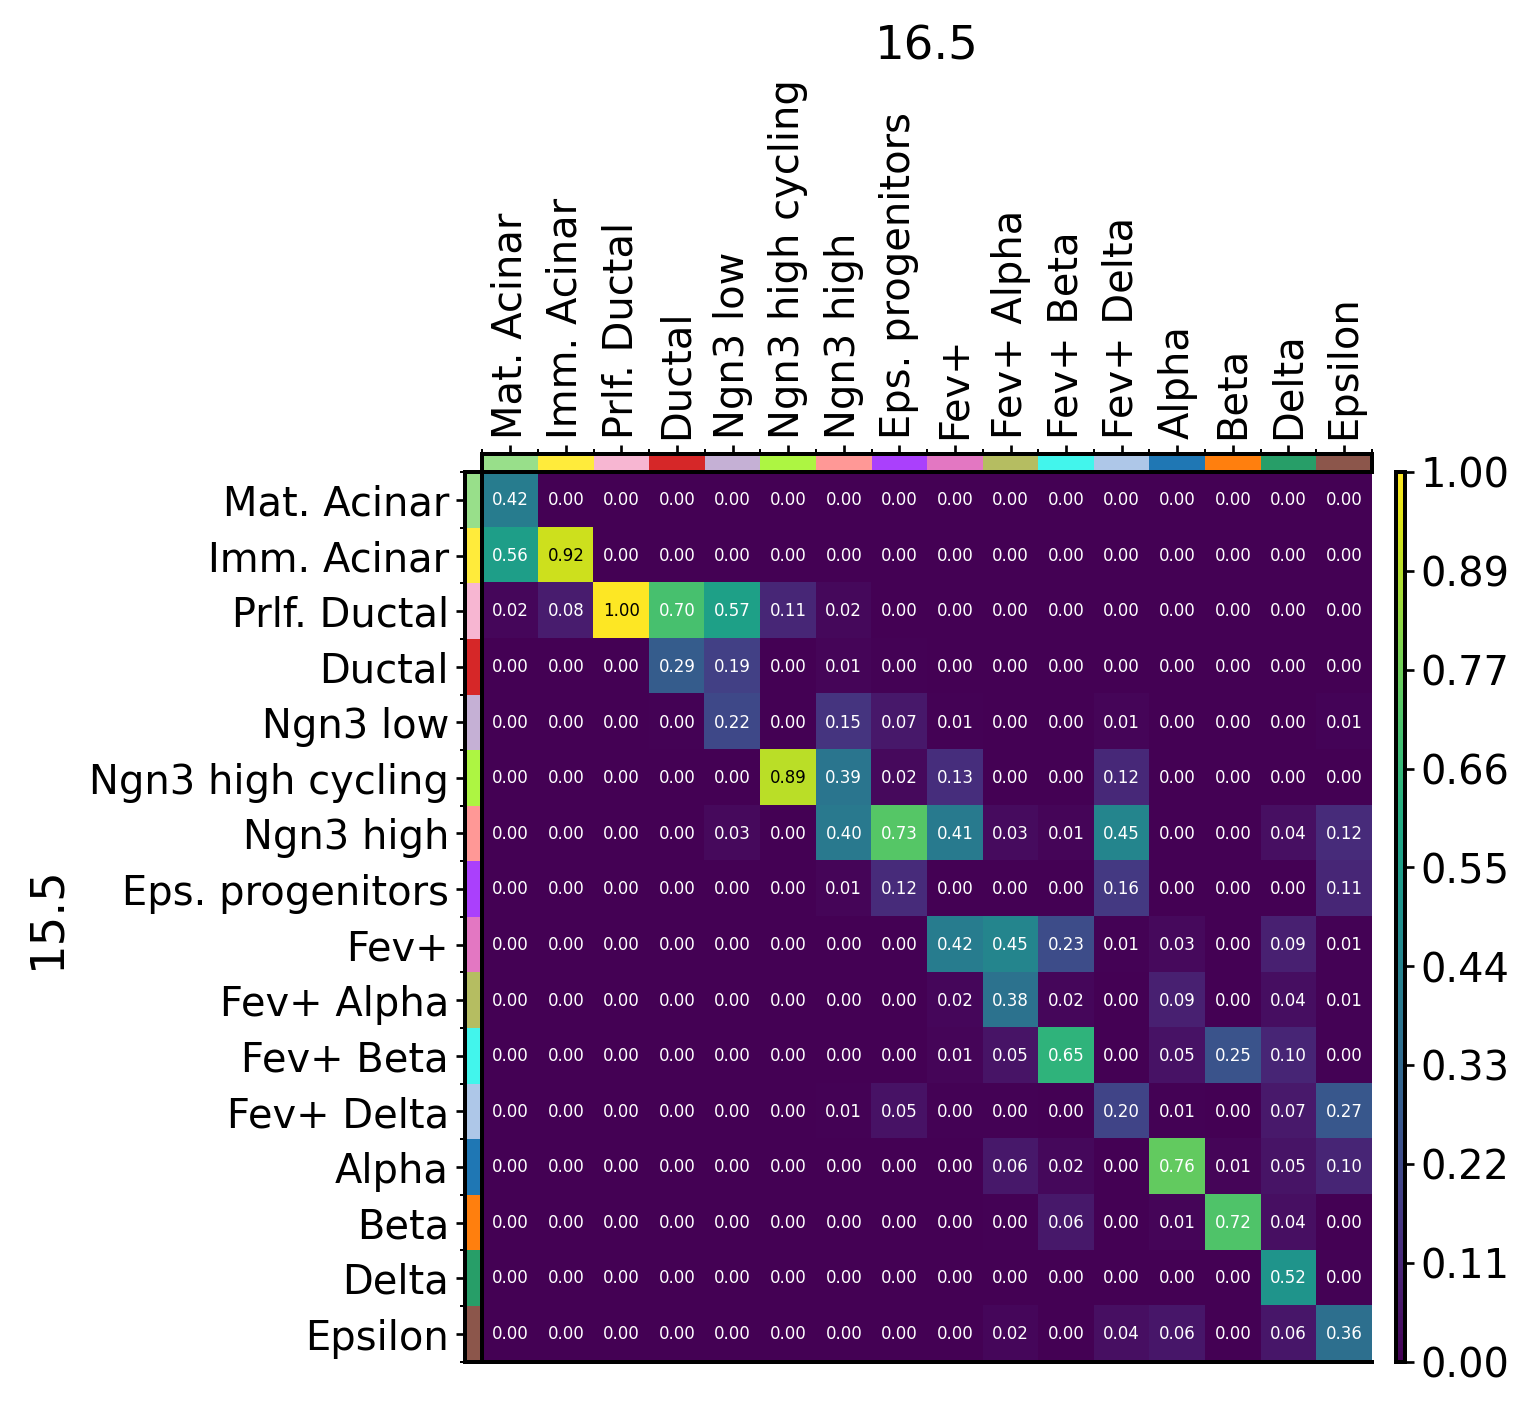

In [22]:
mpl.cell_transition(tp0, dpi=120, fontsize=5)

In [23]:
tp0.save(os.path.join(output_dir, "TemporalProblem.pkl"), overwrite=True)